In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.tri as tri
import os

In [2]:
def tau_p(p1,k1,Nn):
    g=0.1
    return g*Nn**2/(np.pi**2*k1*p1**2)

def MSD_Rouse(t,F1,ta,T1=1.7,Nn=100,k1=5):
    ps=np.arange(1,Nn+1,1)
    g=0.1
    tp=tau_p(ps,k1,Nn)
    val=(tp*(T1+F1**2*ta*tp**2/(g*(tp**2-ta**2)))*(1-np.exp(-t/tp))/(2*Nn*g)
        -(F1*ta*tp)**2*(1-np.exp(-t/ta))/(2*Nn*g**2*(tp**2-ta**2)))*0.5
        # *np.cos(ps*np.pi*50/Nn)**2
    # print(val.shape)
    
    ret=(6*(T1+F1**2*ta/g)*t/(Nn*g) - 6*F1**2*ta**2*(1-np.exp(-t/ta))/(Nn*g**2)
        + 24*np.sum(val))
    return ret

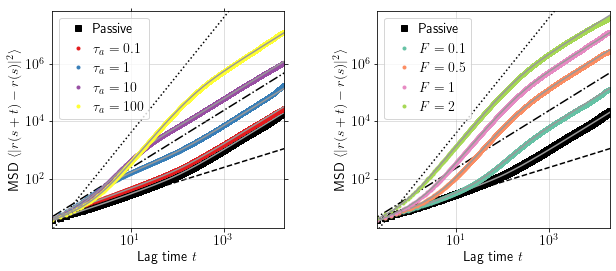

In [36]:
mpl.rcParams.update({'font.size':14, 'text.usetex':True,'legend.handletextpad':0.05})
fig,[ax,ax2]=plt.subplots(1,2,figsize=(10,4),gridspec_kw={'wspace':0.4, 'hspace':0.4})
ind=3
fpath='../../prod_runs/RC_G1200_N100_free/analysis/'
for (name,_) in [('low',1)]:#,('mid',1.0), ('high',2.)]:
    Ts,Fs,Tas=[],[],[]
    Rmax=[]
    betas=[]

    ax.clear()
    colors = pl.cm.Set2(np.linspace(0,1,6))
    count=0
    colors2 = pl.cm.Set1(np.linspace(0,1,6))
    count2=0
    
    fnames=sorted([xx for xx in os.listdir(fpath) if '.npy' in xx],key=lambda x: float(x.split('_')[ind+1].replace('F','')))
    
    for fname in fnames:
        if 'MSD' in fname and 'rep1' in fname:
            # print(fname.split('_'))
            T= float(fname.split('_')[ind].replace('T',''))
            F=float(fname.split('_')[ind+1].replace('F',''))
            Ta=float(fname.split('_')[ind+2].replace('Ta',''))
            kb=float(fname.split('_')[ind+7].replace('kb',''))
            blsize=float(fname.split('_')[ind+6].replace('blocksize',''))
            R0=float(fname.split('_')[ind+4].replace('R0',''))
            dt=float(fname.split('_')[ind+8].replace('dt',''))
            # print(T,F,Ta,Esoft,R0)
            tblck=dt*blsize

            # if not (F==0.0 or (F==1.0 and (Ta in [0.1,1.0,10.,100.0])) or (Ta==100.0 and (F in [0.1,0.5,1.0,2.0]))): continue
            
            npyfile=np.load(fpath+fname)
            t0,=npyfile.shape
            ts=np.arange(0,npyfile.shape[0]*tblck,tblck)
            Nrep=1
            for ix in range(2,10):
                fname_rep=fname.replace('rep1','rep{}'.format(ix))
                if fname_rep in fnames:
                    npyfile+=np.load(fpath+fname_rep)
                    Nrep+=1
            # print(Nrep)
            npyfile=npyfile/Nrep

            Tas.append(Ta)
            Fs.append(F)
            # slope=np.gradient(np.log(npyfile))/np.gradient(np.log(ts))
            # slope_non_zero=np.array([xx for xx in slope if 3>xx>1e-4])
            # Rmax.append(np.max(slope))
            # print(np.mean(slope_non_zero))
            
            if F==0.0:
                ax.loglog(ts,npyfile,'ks', label='Passive')
                ax2.loglog(ts,npyfile,'ks', label='Passive')
                ax.loglog(ts,[MSD_Rouse(xx,F,Ta) for xx in ts],'-',c='0.6')
                ax2.loglog(ts,[MSD_Rouse(xx,F,Ta) for xx in ts],'-',c='0.6')
                # ax2.semilogx(ts, slope, 'ks-',label='Passive')
                
                # ax.set_title('$\\tau_a={}$'.format(Ta))
            if F==1.0 and (Ta in [0.1,1.0,10.,100.0]):
                ax.loglog(ts,npyfile,'.', c=colors2[count2],label="$\\tau_a={}$".format(Ta).replace(".0", ""))
                ax.loglog(ts,[MSD_Rouse(xx,F,Ta) for xx in ts],'-',c='0.6')
                count2+=1
            if Ta==100.0 and (F in [0.1,0.5,1.0,2.0]):
                ax2.loglog(ts,npyfile,'.', c=colors[count],label="$F={}$".format(F).replace(".0", ""))
                count+=1
                # ax2.semilogx(ts, slope, '.-',label=Ta)
                ax2.loglog(ts,[MSD_Rouse(xx,F,Ta) for xx in ts],'-',c='0.6',)

            # if F==0 and Ta==1:
            #     Fs.append(0)
            #     Tas.append(0.1)
            #     Rmax.append(np.max(slope))

            #     Fs.append(0)
            #     Tas.append(0.1)
            #     Rmax.append(np.max(slope))
                
            #     Fs.append(0)
            #     Tas.append(10)
            #     Rmax.append(np.max(slope))                
            
    ori=np.array([1e-2,1e5])
    m=20
    t1=10.3
    
    for axi in [ax,ax2]:
        axi.set_xticks([1,1e1,1e2,1e3,1e4])
        axi.set_yticks([1,1e1,1e2,1e3,1e4,1e5,1e6])
        axi.set_ylim(2,7e7)
        axi.set_xlim(2e-1,2e4)
        axi.grid(True,alpha=0.5, which='both')
        axi.legend(loc='upper left',ncol=1)

        axi.loglog(ori, 0.4*m*ori**0.5, 'k--',zorder=0,label='$\\sim t^{0.5}$')
        axi.loglog(ori, 1.2*m*ori, 'k-.',zorder=0, label='$\\sim t$')
        axi.loglog(ori,2*m*ori**2, 'k:',zorder=0,label='$\\sim t^{2}$')

        axi.set_xlabel('Lag time $t$')
        axi.set_ylabel('MSD $\\langle |r(s+t)-r(s)|^2\\rangle$')

        #, bbox_to_anchor=(0.,-0.55))
    # ax2.legend(loc='lower left',ncol=3, bbox_to_anchor=(0.,-0.55))
        
    # ax2.set_xticks([1,1e1,1e2,1e3,1e4])
    fig.savefig(fpath+'../plots/MSD.png'.format(name), dpi=300, bbox_inches='tight')

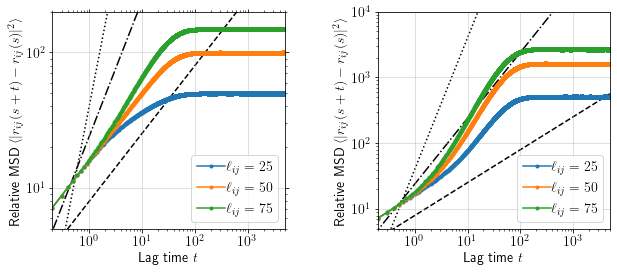

In [39]:
mpl.rcParams.update({'font.size':14, 'text.usetex':True,'legend.handletextpad':0.05})
fig,[ax,ax2]=plt.subplots(1,2,figsize=(10,4),gridspec_kw={'wspace':0.4, 'hspace':0.4})
ind=3
fpath='../../prod_runs/RC_G1200_N100_free/analysis/'
for (name,_) in [('low',1)]:#,('mid',1.0), ('high',2.)]:
    Ts,Fs,Tas=[],[],[]
    Rmax=[]
    betas=[]

    ax.clear()
    colors = pl.cm.Set2(np.linspace(0,1,6))
    count=0
    fnames=sorted([xx for xx in os.listdir(fpath) if '.npz' in xx],key=lambda x: float(x.split('_')[ind+1].replace('F','')))
    
    for fname in fnames:
        if 'RelMSD' in fname and 'rep1' in fname:
            # print(fname.split('_'))
            T= float(fname.split('_')[ind].replace('T',''))
            F=float(fname.split('_')[ind+1].replace('F',''))
            Ta=float(fname.split('_')[ind+2].replace('Ta',''))
            kb=float(fname.split('_')[ind+7].replace('kb',''))
            blsize=float(fname.split('_')[ind+6].replace('blocksize',''))
            R0=float(fname.split('_')[ind+4].replace('R0',''))
            dt=float(fname.split('_')[ind+8].replace('dt',''))
            # print(T,F,Ta,Esoft,R0)
            tblck=dt*blsize

            # if not (F==0.0 or (F==1.0 and (Ta in [0.1,1.0,10.,100.0])) or (Ta==100.0 and (F in [0.1,0.5,1.0,2.0]))): continue
            
            npzfile=np.load(fpath+fname)
            msd25,msd50,msd75=npzfile['msd25'],npzfile['msd50'],npzfile['msd75']
            
            # print(msd25.shape,msd50.shape)
            ts=np.arange(0,msd25.shape[0]*tblck,tblck)
            Nrep=1
            for ix in range(2,10):
                fname_rep=fname.replace('rep1','rep{}'.format(ix))
                if fname_rep in fnames:
                    npzfile=np.load(fpath+fname_rep)
                    msd25+=npzfile['msd25']
                    msd50+=npzfile['msd50']
                    msd75+=npzfile['msd75']

                    Nrep+=1
            # print(Nrep)
            msd25=msd25/Nrep
            msd50=msd50/Nrep
            msd75=msd75/Nrep

            Tas.append(Ta)
            Fs.append(F)
            # slope=np.gradient(np.log(npyfile))/np.gradient(np.log(ts))
            # slope_non_zero=np.array([xx for xx in slope if 3>xx>1e-4])
            # Rmax.append(np.max(slope))
            # print(np.mean(slope_non_zero))
            
            if F==0.0:
                ax.loglog(ts,msd25,'.-', label='$\\ell_{ij}=25$')
                ax.loglog(ts,msd50,'.-', label='$\\ell_{ij}=50$')
                ax.loglog(ts,msd75,'.-', label='$\\ell_{ij}=75$')
                # ax.set_title('Passive')
                # ax.loglog(ts,[MSD_Rouse(xx,F,Ta) for xx in ts],'-',c='0.6')
                # ax2.loglog(ts,[MSD_Rouse(xx,F,Ta) for xx in ts],'-',c='0.6')
                # ax2.semilogx(ts, slope, 'ks-',label='Passive')
                
                # ax.set_title('$\\tau_a={}$'.format(Ta))
            if F==0.5 and Ta ==30.0:
                ax2.loglog(ts,msd25,'.-', label='$\\ell_{ij}=25$')
                ax2.loglog(ts,msd50,'.-', label='$\\ell_{ij}=50$')
                ax2.loglog(ts,msd75,'.-', label='$\\ell_{ij}=75$')
                # ax2.set_title("$F={}\ \\tau_a={}$".format(F,Ta).replace(".0",""))
                # ax.loglog(ts,[MSD_Rouse(xx,F,Ta) for xx in ts],'-',c='0.6')
            if Ta==100.0 and (F in [0.1,0.5,1.0,2.0]):
                # ax2.loglog(ts,msd25,'o', c=colors[count],label="$F={}$".format(F).replace(".0", ""))
                count+=1
                # ax2.semilogx(ts, slope, '.-',label=Ta)
                # ax2.loglog(ts,[MSD_Rouse(xx,F,Ta) for xx in ts],'-',c='0.6',)

            # if F==0 and Ta==1:
            #     Fs.append(0)
            #     Tas.append(0.1)
            #     Rmax.append(np.max(slope))

            #     Fs.append(0)
            #     Tas.append(0.1)
            #     Rmax.append(np.max(slope))
                
            #     Fs.append(0)
            #     Tas.append(10)
            #     Rmax.append(np.max(slope))                
            
    ori=np.array([1e-2,1e5])
    m=20
    t1=10.3
    
    for axi in [ax,ax2]:
        axi.set_xticks([1,1e1,1e2,1e3,1e4])
        axi.set_yticks([1,1e1,1e2,1e3,1e4,1e5,1e6])
        axi.set_ylim(5,2e2)
        axi.set_xlim(2e-1,5e3)
        axi.grid(True,alpha=0.5, which='major')
        axi.legend(loc='lower right',ncol=1)

        axi.loglog(ori, 0.4*m*ori**0.5, 'k--',zorder=0,label='$\\sim t^{0.5}$')
        axi.loglog(ori, 1.2*m*ori, 'k-.',zorder=0, label='$\\sim t$')
        axi.loglog(ori,2*m*ori**2, 'k:',zorder=0,label='$\\sim t^{2}$')

        axi.set_xlabel('Lag time $t$')
        axi.set_ylabel('Relative MSD $\\langle |r_{ij}(s+t)-r_{ij}(s)|^2\\rangle$')

        #, bbox_to_anchor=(0.,-0.55))
    # ax2.legend(loc='lower left',ncol=3, bbox_to_anchor=(0.,-0.55))
    ax2.set_ylim(5,1e4)
    # ax2.set_xticks([1,1e1,1e2,1e3,1e4])
    fig.savefig(fpath+'../plots/relMSD.png'.format(name), dpi=300, bbox_inches='tight')